## Demo Notebook
In this demo notebook, the use of the `simple_search` function and the `StatefulLSTM` wrapper class are demonstrated.

In [8]:
import pandas as pd
import numpy as np
np.random.seed(66)
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8')
plt.rcParams['font.size'] = 12
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [110]:
# Set up rmse function
def rmse(true, predicted):
    return np.round(np.sqrt(np.mean(np.square(predicted - true))), 4)

### Generating Synthetic Data

Here we generate a synthetic univariate time series that will allow for better demonstrating the advantages of stateful LSTM-s as well as the use of the wrapper class.

The configuration for the synthetic data is borrowed from [\[1\]](https://github.com/Humboldt-WI/adams/tree/master).


In [41]:
# Length for our time series
series_length = np.arange(240)
# Synthetic series
time_series = np.sin(series_length)

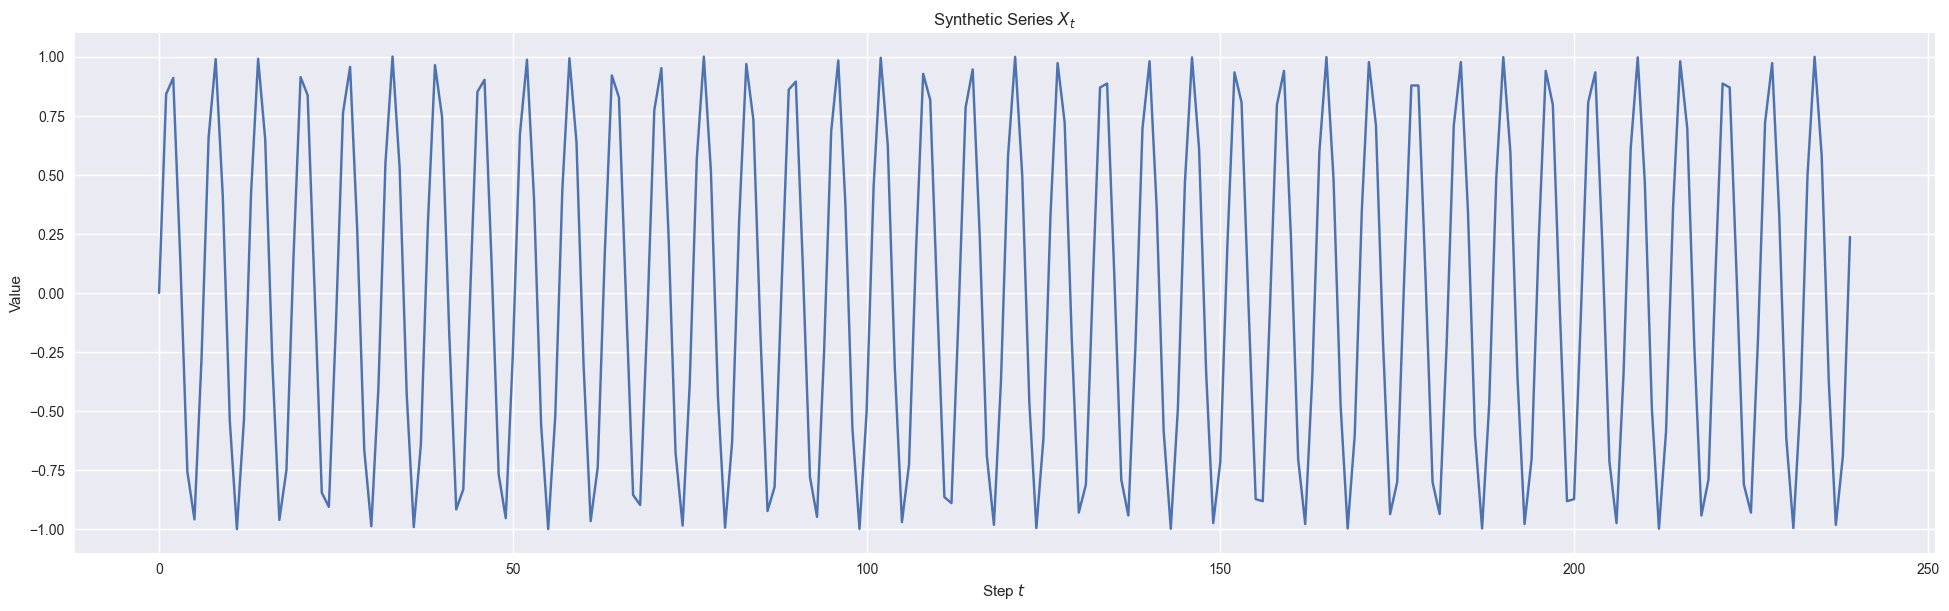

In [42]:
plt.figure(
    figsize=(24, 6.75)
)
plt.plot(time_series)
plt.title('Synthetic Series $Y_t$')
plt.ylabel('Value')
plt.xlabel('Step $t$')
plt.show()
plt.close()

In [48]:
# Use lag order of 1
lag_order = 1
# Needed not to break state forwarding
batch_size = lag_order

In [44]:
# 0.6-0.2-0.2 train-val-test split
test_len = int(len(series_length)*0.2)
val_len = test_len
train_len = len(series_length) - 2*test_len

train = time_series[:train_len]
val = time_series[train_len:train_len+val_len]
test = time_series[-test_len:]

# Function to reshape as LSTM inputs:
def generate_tensors(series, timesteps):
    
    dataX, dataY = [], []
    
    for i in range(0, len(series) - timesteps):
        x = np.reshape(series[i:i + timesteps], (-1,1))
        dataX.append(x)
        y = series[i +timesteps]
        dataY.append(y)
    
    return np.array(dataX), np.array(dataY)
                 

# Generate tensors
X_train, y_train = generate_tensors(train, lag_order)
X_val, y_val = generate_tensors(val, lag_order)
X_test, y_test = generate_tensors(test, lag_order)


### Using `simple_search`: 

In [55]:
# Import simple_search
from stateful_lstm import simple_search

In [57]:
# Conduct simple search:
# Function will check from 1 to 10 units in one LSTM layer
# Regularization is disabled
# Print statements are activated by verbose=True
simple_search(
    x=X_train,
    y=y_train,
    batch_size=batch_size,
    timesteps=lag_order,
    train_epochs=50,
    validation_data=(X_val, y_val),
    num_layers=(1,2,1),
    num_units=(1,11,1),
    regularize=False,
    verbose=True
)

Trial with 1 Layer(s), 1 Unit(s). Model is Being Fitted and Evaluated...
------------------------------------------------------------------------------------------------------------------------
Trial Finished. New Best Parameters Found: Layers: 1, Units: 1, Val Loss: 0.1180, Corresponding Train Loss: 0.7895.
Trial with 1 Layer(s), 2 Unit(s). Model is Being Fitted and Evaluated...
------------------------------------------------------------------------------------------------------------------------
Trial Finished. New Best Parameters Found: Layers: 1, Units: 2, Val Loss: 0.0178, Corresponding Train Loss: 0.0273.
Trial with 1 Layer(s), 3 Unit(s). Model is Being Fitted and Evaluated...
------------------------------------------------------------------------------------------------------------------------
Trial Finished. No Best Parameters Found at This Stage. Moving On...
Trial with 1 Layer(s), 4 Unit(s). Model is Being Fitted and Evaluated...
--------------------------------------------

### Using `.stateful_fit()` with validation data

In [66]:
from keras.optimizers import Adam
adam = Adam(learning_rate=1e-4)

# Set up Keras LSTM model
model = keras.Sequential()
model.add(layers.LSTM(7,
                         activation = 'tanh',
                         recurrent_activation = 'sigmoid',
                         recurrent_dropout=0,
                         unroll=False,
                         use_bias = True,
                         stateful = True,
                         return_sequences = False,
                         batch_input_shape = (batch_size, lag_order, 1)
                         ))
model.add(layers.Dense(1))
# Compile model with standard parameters
model.compile(loss = 'mean_squared_error', optimizer = adam)
model.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_19 (LSTM)              (1, 7)                    252       
                                                                 
 dense_19 (Dense)            (1, 1)                    8         
                                                                 
Total params: 260
Trainable params: 260
Non-trainable params: 0
_________________________________________________________________


In [67]:
# Import the stateful LSTM class
from stateful_lstm import StatefulLSTM

In [68]:
# Initialize wrapper class
stateful_model = StatefulLSTM(model)

# Use stateful fit with built-in EarlyStopping and validation data
stateful_model.stateful_fit(
    x=X_train,
    y=y_train,
    batch_size=batch_size,
    epochs=50,
    verbose=True,
    validation_data=(X_val,y_val),
    early_stopping=True,
    min_delta=1e-3,
    patience=3
)

Epoch 1/50 - 51.33s - loss: 0.5253 - val_loss: 0.1003
----------------------------------------------------------------------------------------------------
Epoch 2/50 - 48.11s - loss: 0.0930 - val_loss: 0.0348
----------------------------------------------------------------------------------------------------
Epoch 3/50 - 47.53s - loss: 0.0313 - val_loss: 0.0197
----------------------------------------------------------------------------------------------------
Epoch 4/50 - 47.20s - loss: 0.0262 - val_loss: 0.0217
----------------------------------------------------------------------------------------------------
Epoch 5/50 - 47.48s - loss: 0.0297 - val_loss: 0.0293
----------------------------------------------------------------------------------------------------
Epoch 6/50 - 48.03s - loss: 0.0348 - val_loss: 0.0330
----------------------------------------------------------------------------------------------------
Epoch 7/50 - 47.48s - loss: 0.0364 - val_loss: 0.0351
----------------

**Calling `.train_losses` and `.val_losses` from the stateful model:**

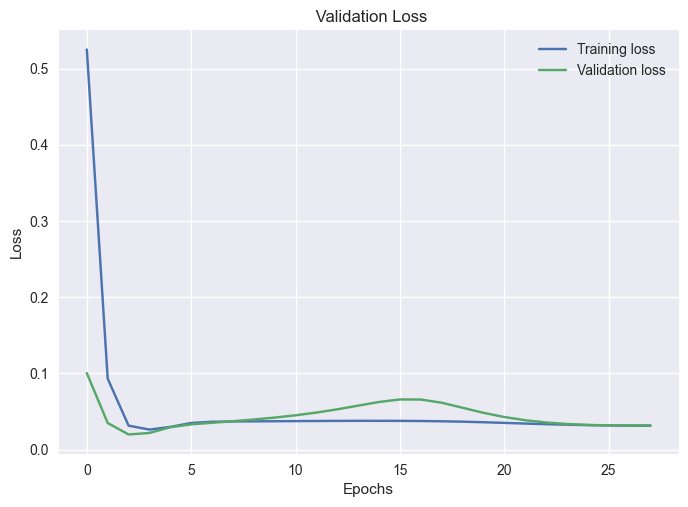

In [90]:
# Plot losses by calling .train_losses and .val_losses
plt.plot(stateful_model.train_losses, label='Training loss')
plt.plot(stateful_model.val_losses, label='Validation loss')
plt.title(' Validation Loss') # RENAME
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
plt.close()

### Using `.stateful_fit()` without validation data:

In [93]:
# Concatenate train and validation datasets
X_retrain = np.concatenate([X_train, X_val], axis=0)
y_retrain = np.concatenate([y_train, y_val], axis=0)

# Reinitialize stateful Keras model
model = keras.Sequential()
model.add(layers.LSTM(7,
                         activation = 'tanh',
                         recurrent_activation = 'sigmoid',
                         recurrent_dropout=0,
                         unroll=False,
                         use_bias = True,
                         stateful = True,
                         return_sequences = False,
                         batch_input_shape = (batch_size, lag_order, 1)
                         ))
model.add(layers.Dense(1))
# Compile model with standard parameters
model.compile(loss = 'mean_squared_error', optimizer = adam)
model.summary()

# Re-initialize Stateful LSTM wrapper class
stateful_model = StatefulLSTM(model)

# Use stateful fit with built-in EarlyStopping and without validation data
stateful_model.stateful_fit(
    x=X_retrain,
    y=y_retrain,
    batch_size=batch_size,
    epochs=50,
    verbose=True,
    validation_data=None,
    early_stopping=True,
    min_delta=1e-3,
    patience=3
)

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_21 (LSTM)              (1, 7)                    252       
                                                                 
 dense_21 (Dense)            (1, 1)                    8         
                                                                 
Total params: 260
Trainable params: 260
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50 - 65.26s - loss: 0.5225
----------------------------------------------------------------------------------------------------
Epoch 2/50 - 64.01s - loss: 0.0550
----------------------------------------------------------------------------------------------------
Epoch 3/50 - 62.92s - loss: 0.0101
----------------------------------------------------------------------------------------------------
Epoch 4/50 - 63.02s - loss: 0.0085
--------

### Using the `.predict()` wrapper method:

In [97]:
y_pred = stateful_model.predict(x=X_test,
                                batch_size=batch_size)

47/47 [==============================] - 1s 10ms/step


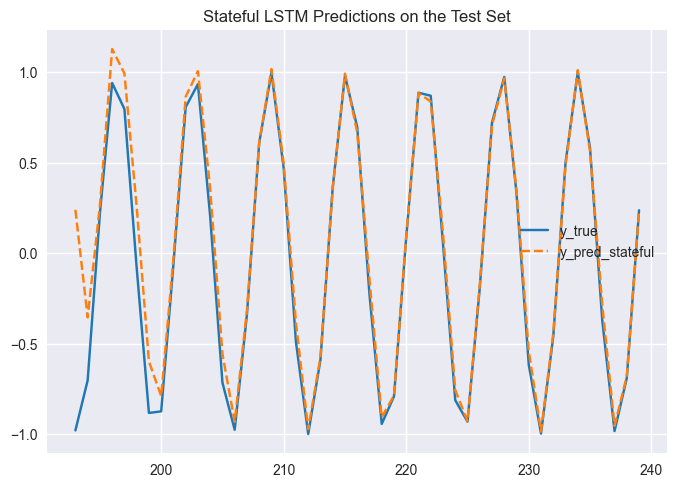

In [102]:
df = pd.DataFrame({'y_pred_stateful': y_pred.flatten(), 'y_test':  y_test.flatten()})
df.index = range(len(time_series)-len(y_test), len(time_series))
plt.plot(df['y_test'], label='y_true', color='#1f77b4')
plt.plot(df['y_pred_stateful'], label='y_pred_stateful', linestyle='--', color='#ff7f0e')
plt.title('Stateful LSTM Predictions on the Test Set')
plt.legend()
plt.savefig(r'Plots\stateful_preds.png', dpi=300)
plt.show()
plt.close()

### `.save()`, `.save_weights()`

In [101]:
# Save model
stateful_model.save(r'Model\stateful_model.h5')
# Save weights
stateful_model.save(r'Model\stateful_model_weights.h5')

### Comparison with Stateless LSTM

In [106]:
# Set up EarlyStopping callback
callback = keras.callbacks.EarlyStopping(
    monitor='loss',
    min_delta=1e-3,
    patience=3
)

# Set up stateless Keras model with same configuration
model = keras.Sequential()
model.add(layers.LSTM(7,
                         activation = 'tanh',
                         recurrent_activation = 'sigmoid',
                         recurrent_dropout=0,
                         unroll=False,
                         use_bias = True,
                         stateful = False,
                         return_sequences = False,
                         batch_input_shape = (batch_size, lag_order, 1)
                         ))
model.add(layers.Dense(1))
# Compile model with standard parameters
model.compile(loss = 'mean_squared_error', optimizer = adam)
model.summary()

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_23 (LSTM)              (1, 7)                    252       
                                                                 
 dense_23 (Dense)            (1, 1)                    8         
                                                                 
Total params: 260
Trainable params: 260
Non-trainable params: 0
_________________________________________________________________


In [107]:
# Fit without validation, on the retraining set
model.fit(
    x=X_retrain,
    y=y_retrain,
    epochs=50,
    batch_size=batch_size,
    verbose=1,
    shuffle=False,
    callbacks=[callback]
)

Epoch 1/50
190/190 [==============================] - 4s 7ms/step - loss: 0.4604
Epoch 2/50
190/190 [==============================] - 1s 7ms/step - loss: 0.4436
Epoch 3/50
190/190 [==============================] - 1s 7ms/step - loss: 0.4324
Epoch 4/50
190/190 [==============================] - 1s 7ms/step - loss: 0.4234
Epoch 5/50
190/190 [==============================] - 1s 7ms/step - loss: 0.4157
Epoch 6/50
190/190 [==============================] - 1s 7ms/step - loss: 0.4090
Epoch 7/50
190/190 [==============================] - 1s 7ms/step - loss: 0.4030
Epoch 8/50
190/190 [==============================] - 2s 8ms/step - loss: 0.3977
Epoch 9/50
190/190 [==============================] - 2s 8ms/step - loss: 0.3929
Epoch 10/50
190/190 [==============================] - 2s 10ms/step - loss: 0.3887
Epoch 11/50
190/190 [==============================] - 1s 8ms/step - loss: 0.3848
Epoch 12/50
190/190 [==============================] - 1s 7ms/step - loss: 0.3814
Epoch 13/50
190/190 [===

In [108]:
# Predict
y_pred_stateless = model.predict(X_test, batch_size=batch_size)

47/47 [==============================] - 1s 6ms/step


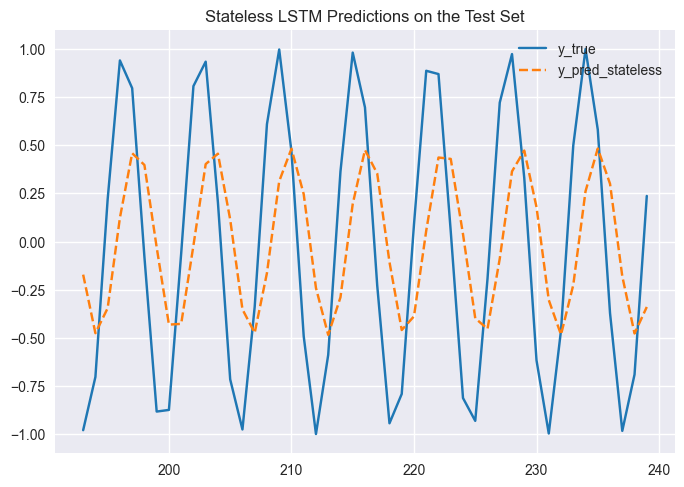

In [109]:
# Add to our df and plot
df['y_pred_stateless'] = y_pred_stateless.flatten()
plt.plot(df['y_test'], label='y_true', color='#1f77b4')
plt.plot(df['y_pred_stateless'], label='y_pred_stateless', linestyle='--', color='#ff7f0e')
plt.title('Stateless LSTM Predictions on the Test Set')
plt.legend()
plt.savefig(r'Plots\stateless_preds.png', dpi=300)
plt.show()
plt.close()

In [115]:
print(f"Stateful LSTM RMSE: {rmse(df['y_test'], df['y_pred_stateful'])}.\nStateless LSTM RMSE: {rmse(df['y_test'], df['y_pred_stateless'])}")

Stateful LSTM RMSE: 0.2057.
Stateless LSTM RMSE: 0.5954
